### Import

In [17]:
# librerias basicas
import os
import numpy as np
from copy import deepcopy
from tqdm import tqdm as tqdm
import time
import gc
# graficos
import matplotlib.cm as cm
import matplotlib.pyplot as plt
# videos
import cv2
# Imagenes medicas
import nibabel as nib
# optimizacion
import scipy.linalg
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
from scipy.stats import linregress
# cargar data
import pickle as pkl
import warnings
# eliminar advertencias
warnings.filterwarnings('ignore')

### Utils

In [18]:
def geo_mean(iterable):
  """
  Compute geometric mean of an array
  """
  a = np.array(iterable)
  return a.prod()**(1.0/len(a))
  
def read_image_data(path, file):
  """
  Read an image from the MNI atlas
  """
  img = nib.load(os.path.join(path, file))
  data = img.get_fdata()
  return data

## Display del MNI atlas

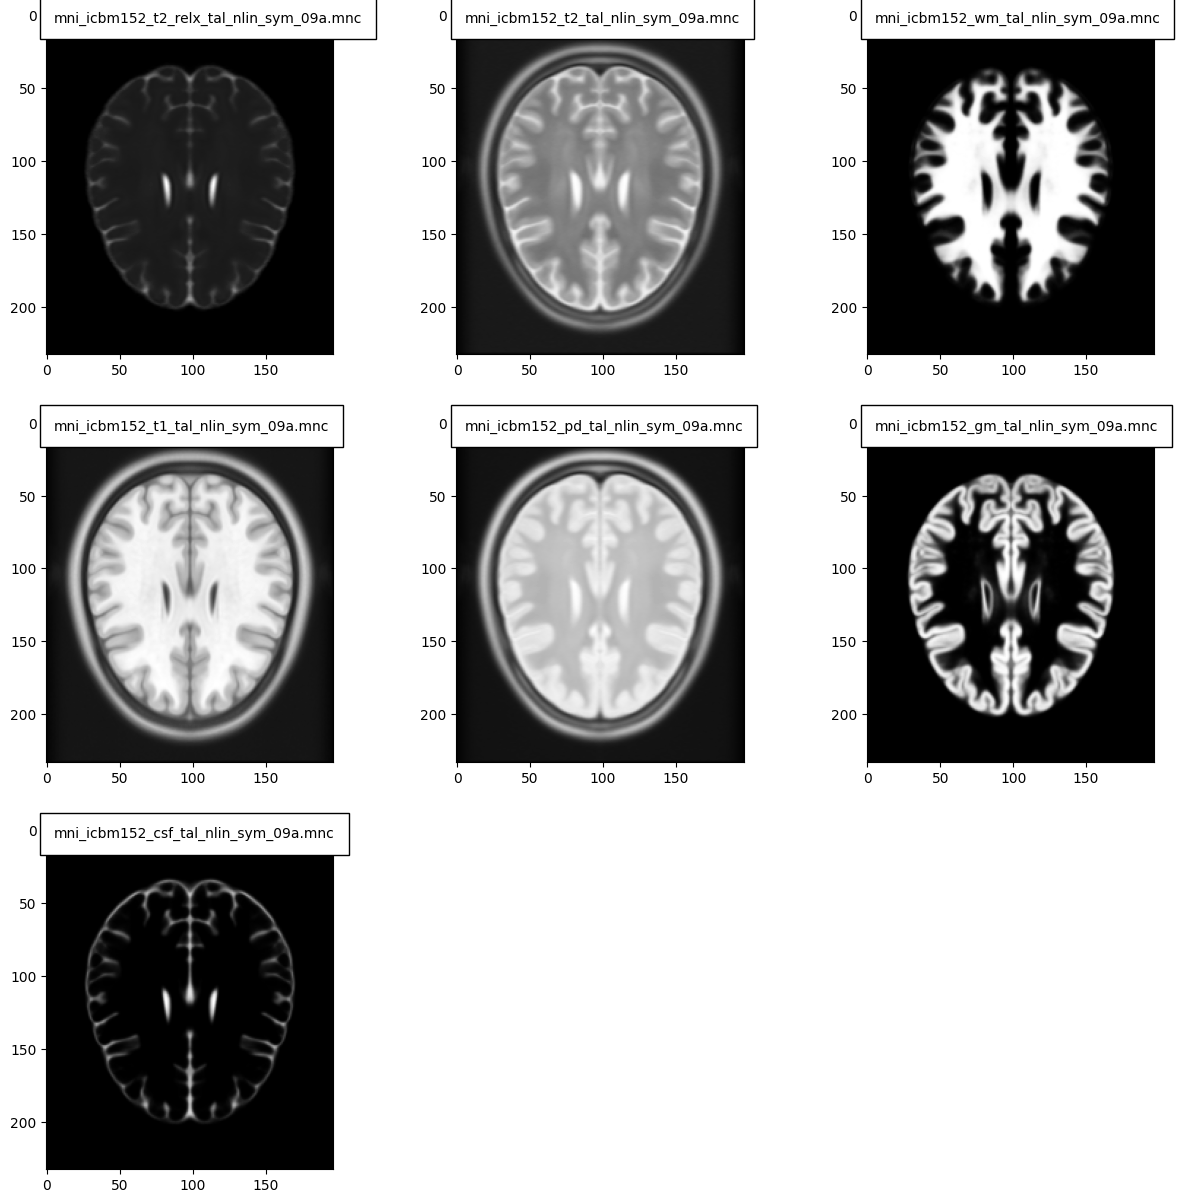

In [19]:
path = '/Users/Maxy/Desktop/tumor_growth/mni_icbm152_nlin_sym_09a_minc2'
files = ['mni_icbm152_t2_relx_tal_nlin_sym_09a.mnc',
         'mni_icbm152_t2_tal_nlin_sym_09a.mnc',
         'mni_icbm152_wm_tal_nlin_sym_09a.mnc',
         'mni_icbm152_t1_tal_nlin_sym_09a.mnc',
         'mni_icbm152_pd_tal_nlin_sym_09a.mnc',
         'mni_icbm152_gm_tal_nlin_sym_09a.mnc',
         'mni_icbm152_csf_tal_nlin_sym_09a.mnc']
f, ax = plt.subplots(3, 3, figsize=(15,15))
for i, file in enumerate(files):
  k, l = i//3, i%3
  data = read_image_data(path, file)
  ax[k, l].imshow(data[100], cmap="gray")
  ax[k, l].grid(False)
  ax[k, l].text(5, 5, file, bbox={'facecolor': 'white', 'pad': 10})
ax[-1, -2].axis('off')  
ax[-1, -1].axis('off')
f.show()

In [20]:
# Definir los nombres de los archivos para los diferentes tipos de tejido
white_matter = 'mni_icbm152_wm_tal_nlin_sym_09a.mnc'
grey_matter = 'mni_icbm152_gm_tal_nlin_sym_09a.mnc'
csf = 'mni_icbm152_csf_tal_nlin_sym_09a.mnc'
outside_lim = 'mni_icbm152_t2_relx_tal_nlin_sym_09a.mnc'

# Leer las imágenes utilizando la ruta proporcionada y los nombres de archivo
img = read_image_data(path, 'mni_icbm152_t1_tal_nlin_sym_09a.mnc')
wm = read_image_data(path, white_matter)
gm = read_image_data(path, grey_matter)
csf = read_image_data(path, csf)
out = read_image_data(path, outside_lim)

# Función para normalizar un solo frame de la imagen
def normalize_frame_2D(i, img=img):
    # Crear una copia del frame i de la imagen
    img_norm = img[i].copy()
    
    # Establecemos todos los valores menores a 30 en 0
    zero_index = np.where(img_norm < 30)
    img_norm[zero_index] = 0
    
    # Normalizamos los valores de los píxeles al rango [0, 1]
    img_norm = (img_norm - np.min(img_norm)) / (np.max(img_norm) - np.min(img_norm))
    
    # Establecemos regiones específicas de la imagen en diferentes valores según umbrales

    # Indico la región fuera del cerebro en 0
    out_index = np.where(out[i] < 0.08)
    # Indico la región del LCR (líquido cefalorraquídeo) en 0
    csf_index = np.where(csf[i] > 0.15)
    # Indico la región de materia blanca en 1
    wm_index = np.where(wm[i] > 0.5)
    img_norm[out_index], img_norm[csf_index], img_norm[wm_index] = 0, 0, 1
    
    # Establecer la región de materia gris en 0.5
    gm_index = np.where(np.logical_and(img_norm > 0, img_norm < 1))
    img_norm[gm_index] = 0.5
    
    return img_norm

# Función para normalizar todo el volumen de la imagen de RM
def normalize_MRI(img=img):
    # Crear una copia del volumen completo de la imagen
    new_img = img.copy()
    
    # Normalizar cada frame del volumen de la imagen
    for i in range(img.shape[0]):
        new_img[i] = normalize_frame_2D(i, img)
    
    return new_img

# Función para comparar un frame específico antes y después de la normalización
def compare_with_norm(i, img=img):
    # Crear una figura con dos subplots
    f, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    # Mostrar el frame original antes de la normalización
    ax[0].imshow(1 - img[i], label='Antes de la normalización', cmap="gray")
    ax[0].grid(False)
    ax[0].text(5, 5, 'Imagen cruda ' + str(i), bbox={'facecolor': 'white', 'pad': 10})
    
    # Normalizar el frame
    img_norm = normalize_frame_2D(i, img)
    
    # Mostrar el frame después de la normalización
    ax[1].imshow(1 - img_norm, label='Después de la normalización', cmap= "gray")
    ax[1].text(5, 5, 'Imagen binaria ' + str(i), bbox={'facecolor': 'white', 'pad': 10})
    ax[1].grid(False)
    
    # Mostrar la figura
    f.show()



Comparamos antes y despues de la normalizacion

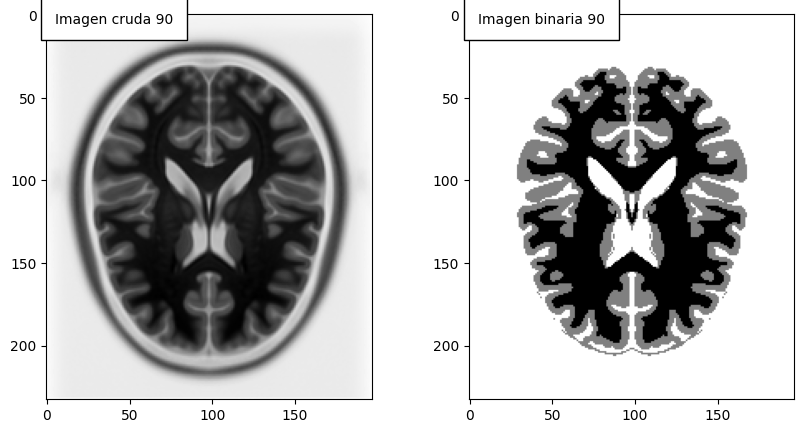

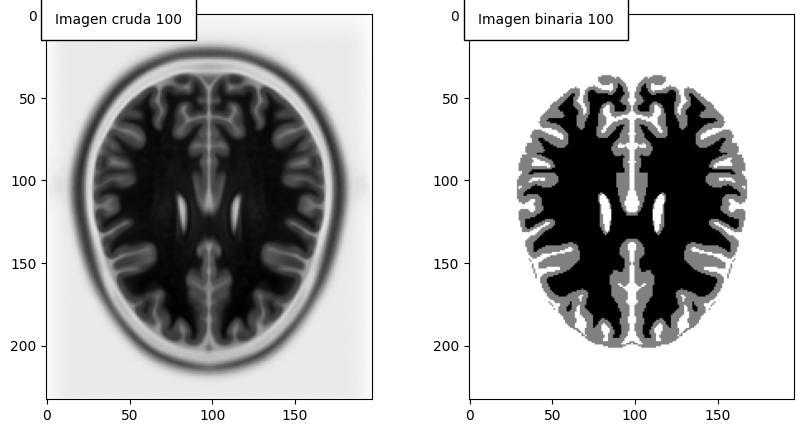

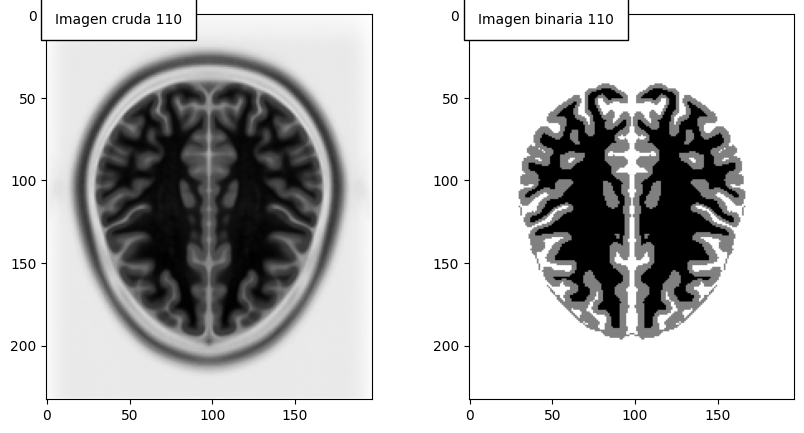

In [21]:
compare_with_norm(90)
compare_with_norm(100)
compare_with_norm(110)

## Lattice Bolztmann Method on 3D IRM



Parámetros:

- IRM: Volumen de la imagen de resonancia magnética.

- x0: Coordenadas iniciales del tumor.

- a, b, L0: Parámetros para inicializar la densidad del tumor.

- tau_1, tau_2: Tiempos de relajación para el método.

- d_w: Difusividad en la materia blanca.

- rho: Densidad del tumor.

- dx, dt: Tamaño del paso espacial y temporal.



Atributos:

- d_w, D_w, D_g: Matrices de difusión para materia blanca y gris.

- rho, dx, dt: Densidad, tamaño del paso espacial y temporal.

- e, w: Vectores de velocidad y pesos para el modelo Lattice Boltzmann.

- M, S_inv_w, S_inv_g: Matrices para la transformación y los inversos de los tiempos de relajación.

- A_w, A_g: Matrices de colisión.

- IRM, domain, n, nz, ny, nx: Imagen IRM y dimensiones del dominio.

- x0, a, b, L0: Parámetros iniciales para la distribución del tumor.

- u0, u, u_alpha: Campos de densidad inicial y actual del tumor.

Flujo de la Simulación

- **Inicialización**: Los parámetros del modelo y las matrices se inicializan, y el campo de densidad inicial del tumor se calcula.


- **Colisión**: Se aplica la operación de colisión usando las matrices de colisión A_w y A_g.


- **Streaming**: Los valores se propagan en la malla según las reglas de Lattice Boltzmann.


- **Condiciones de Frontera**: Se aplican las condiciones de frontera para el dominio.


- **Actualización**: Se actualiza el campo de densidad del tumor.


- **Iteración**: El proceso se repite durante el tiempo especificado T.

In [ ]:
#Codigo  pendiente ...

## Cranck Nicholson on 2D Image

```python
def __init__(self, D, rho, Lx, Ly, Nx, Ny=, dt, T, sigma, theta):
```

1. **`D`**: Coeficiente de difusión.
    - Constante que indica la rapidez con la que una sustancia se dispersa en el medio.
    - **Ejemplo**: A valores de `D` grandes, mayor sera la dispersion.

2. **`rho`**: Tasa de crecimiento o reacción.
    - Representa la velocidad a la que la sustancia crece o reacciona en el medio.
    - **Ejemplo**: Una `rho` alta implica un incremento rápido; una `rho` baja indica un crecimiento lento.

3. **`Lx` y `Ly`**: Dimensiones del área de simulación.
    - `Lx` es el tamaño del área en la dirección x (horizontal) y `Ly` en la dirección y (vertical).
    - **Ejemplo**: Si `Lx` y `Ly` son 200, el área de simulación es un cuadrado de 200x200 unidades.

4. **`Nx` y `Ny`**: Número de divisiones en la rejilla en las direcciones x e y.
    - `Nx` es el número de divisiones en la dirección x y `Ny` en la dirección y, lo que define la resolución de la rejilla.
    - **Ejemplo**: Si `Nx` y `Ny` son 100, la rejilla tiene 101 puntos (de 0 a 100) en cada dirección.

5. **`dt`**: Paso de tiempo.
    - Duración de cada paso de tiempo en la simulación.
    - **Ejemplo**: Si `dt` es 0.1, la simulación avanza en intervalos de 0.1 unidades de tiempo.

6. **`T`**: Tiempo total de simulación.
    - Duración total de la simulación en unidades de tiempo.
    - **Ejemplo**: Si `T` es 200, la simulación se ejecutará desde el tiempo 0 hasta el tiempo 200.

7. **`sigma`**: Parámetro que controla la dispersión inicial de la sustancia.
    - Controla cómo de dispersa está la sustancia inicialmente en el área de simulación.
    - **Ejemplo**: Un `sigma` pequeño significa que la sustancia está muy concentrada en un punto; un `sigma` grande indica una dispersión más amplia.

8. **`theta`**: Factor de ponderación para el método de Crank-Nicholson.
    - Parámetro que ajusta la contribución del método explícito e implícito en el esquema de Crank-Nicholson.
    - **Ejemplo**: Si `theta` es 0.5, el esquema es completamente Crank-Nicholson; si `theta` es 1, el esquema es completamente implícito.

In [25]:
class CNicholson2D():
    # Esta función se ejecuta cuando creamos un nuevo objeto de esta clase
    def __init__(self, D=0.1, rho=0.18, Lx=200, Ly=200, Nx=100, Ny=100, dt=0.1, T=200, sigma=1e-3, theta=0.5):
        # Inicializamos las variables que describen las propiedades de la simulación
        self.D = D / ((Lx/Nx)**2)
        self.rho = rho
        self.Lx, self.Ly, self.Nx, self.Ny, self.N = Lx, Ly, Nx, Ny, (Nx+1)*(Ny+1)
        self.x, self.y = np.linspace(0, Lx, Nx+1), np.linspace(0, Ly, Ny+1)
        self.dx, self.dy = self.x[1] - self.x[0], self.y[1] - self.y[0]
        self.dt, self.T, self.Nt = dt, T, int(round(T/float(dt)))
        self.t = np.linspace(0, self.Nt*dt, self.Nt+1)
        self.theta = theta
        self.sigma = sigma
        self.Fx = self.D*self.dt/self.dx**2
        self.Fy = self.D*dt/self.dy**2
        self.A = np.zeros((self.N, self.N))
        self.b = np.zeros(self.N)
        self.u = np.zeros((self.Nt, Nx+1, Ny+1))
        self.distances = {'geom': []}
        self.vitesses = {'t1gd': [], 't2flair': [], 'geom': []}

    # Inicializa la concentración de una sustancia en el centro del área de simulación
    def I(self, x, y):
        l = np.linalg.norm(np.array([x, y])-np.array([self.Lx//2, self.Ly//2]), 2)
        return np.exp(-l**2 / self.sigma)

    # Función principal que ejecuta la simulación
    def simulation(self):
        # Inicializamos la condición inicial (la sustancia está en el centro)
        for i in range(self.Nx+1):
            for j in range(self.Ny+1):
                self.u[0, i, j] = self.I(self.x[i], self.y[j])
        
        # Función lambda para convertir coordenadas 2D a un índice 1D
        m = lambda i, j: j*(self.Nx+1) + i

        # Configuramos las ecuaciones para el borde inferior (j=0)
        j = 0
        for i in range(self.Nx+1):
            p, self.A[p, p] = m(i, j), 1

        # Configuramos las ecuaciones para todos los puntos internos de la rejilla
        for j in range(1, self.Ny):
            i = 0;  p = m(i, j);  self.A[p, p] = 1  # Borde izquierdo
            for i in range(1, self.Nx):  # Puntos interiores
                p = m(i, j)
                self.A[p, m(i, j-1)]  = - self.theta*self.Fy
                self.A[p, m(i-1, j)] = - self.theta*self.Fx
                self.A[p, p] = 1 + 2*self.theta*(self.Fx + self.Fy)
                self.A[p, m(i+1, j)] = - self.theta*self.Fx
                self.A[p, m(i, j+1)] = - self.theta*self.Fy
            i = self.Nx;  p = m(i, j);  self.A[p, p] = 1  # Borde derecho

        # Configuramos las ecuaciones para el borde superior (j=Ny)
        j = self.Ny
        for i in range(self.Nx+1):
            p = m(i, j);  self.A[p, p] = 1

        # Bucle principal de la simulación
        for t in range(self.Nt):
            # Computamos el vector b
            j = 0
            for i in range(self.Nx+1):
                p = m(i, j);  self.b[p] = 0  # Borde inferior
            for j in range(1, self.Ny):
                i = 0;  p = m(i, j);  self.b[p] = 0  # Borde izquierdo
                for i in range(1, self.Nx):  # Puntos interiores
                    p = m(i, j)
                    self.b[p] = self.u[t, i, j] + (1-self.theta) * (
                        self.Fx * (self.u[t, i+1, j] - 2*self.u[t, i, j] + self.u[t, i-1, j]) +
                        self.Fy * (self.u[t, i, j+1] - 2*self.u[t, i, j] + self.u[t, i, j-1])
                    ) + self.dt * self.rho * (self.u[t, i, j] * (1 - self.u[t, i, j]))
                i = self.Nx;  p = m(i, j);  self.b[p] = 0  # Borde derecho
            j = self.Ny
            for i in range(self.Nx+1):
                p = m(i, j);  self.b[p] = 0  # Borde superior

            # Resolvemos el sistema de ecuaciones A*c = b
            c = spsolve(self.A, self.b)

            # Actualizamos u con el vector c
            for i in range(self.Nx+1):
                for j in range(self.Ny+1):
                    if t == self.Nt-1:
                        self.u[t, i, j] = c[m(i, j)]
                    else:
                        self.u[t+1, i, j] = c[m(i, j)]

            # Imprimimos información cada 100 pasos de tiempo y guardamos los resultados
            if t % 100 == 0 and t > 0:
                print('...t = {}...'.format(t))
                d = self.get_distance(t)
                r_rt1gd_t2, r_rt2flair_t2 = d
                delta = r_rt2flair_t2 - r_rt1gd_t2
                self.distances['geom'].append(delta)
                vt1gd = r_rt1gd_t2 / t / self.dt
                self.vitesses['t1gd'].append(vt1gd)
                vt2flair = r_rt2flair_t2 / t / self.dt
                self.vitesses['t2flair'].append(vt2flair)
                vgeom = np.sqrt(vt1gd * vt2flair)
                self.vitesses['geom'].append(vgeom)
                print('vt1gd', vt1gd, 'vt2flair', vt2flair, 'vgeom', vgeom, 'diff', delta)
                pkl.dump([self.u, self.distances, self.vitesses], open('/Users/Maxy/Desktop/tumor_growth/MEDICAL_IMAGE_ANALYSIS/CN2D_image/results_D{}_rho{}.pkl'.format(self.D, self.rho), 'wb'))
                self.viz([t])

        return self.u, self.distances, self.vitesses

    # Esta función calcula la distancia entre dos puntos en una dirección específica
    def get_distance(self, t, tau1=0.8, tau2=0.16):
        i_max = self.Nx // 2
        y = self.u[t, i_max, :]
        idx1 = np.argwhere(np.diff(np.sign(y - y.max() * tau1))).flatten()
        idx2 = np.argwhere(np.diff(np.sign(y - y.max() * tau2))).flatten()
        t1gd, t2flair = (idx1[1] - idx1[0]) / 2, (idx2[1] - idx2[0]) / 2
        t1gd *= 200 / self.Nx
        t2flair *= 200 / self.Nx
        return np.abs(np.array([t1gd, t2flair]))

    # Esta función dibuja las imágenes de los resultados de la simulación
    def viz(self, frames):
        for t in frames:
            plt.imshow(self.u[t], interpolation='gaussian', cmap=cm.hot)
            plt.title(r'$D={0:1.2f} \, \, , \, \, \rho={1:0.2f}$ , t={2:1.1f} dias'.format(self.D, self.rho, t*self.dt))
            plt.grid(False)
            plt.axis('off')
            plt.show()


In [27]:
# Generamos 11 valores igualmente espaciados entre 0.02 y 1.4 para el parámetro D
Ds = np.linspace(0.25, 0.32, 3)
# Generamos 11 valores igualmente espaciados entre 0.002 y 0.2 para el parámetro rho
rhos = np.linspace(0.16, 0.2, 3)


print('Valores para D', Ds)
print('Valores para rho', rhos)

Valores para D [0.25  0.285 0.32 ]
Valores para rho [0.16 0.18 0.2 ]


D = 0.25 , rho = 0.16
...t = 100...
vt1gd 0.3 vt2flair 0.7000000000000001 vgeom 0.45825756949558405 diff 4.0


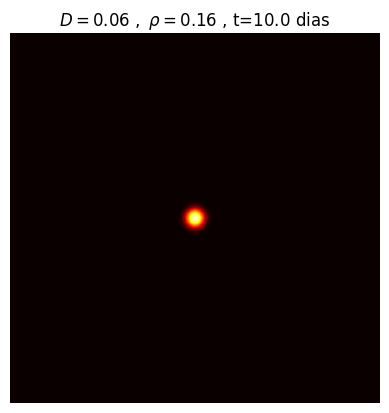

...t = 200...
vt1gd 0.25 vt2flair 0.44999999999999996 vgeom 0.33541019662496846 diff 4.0


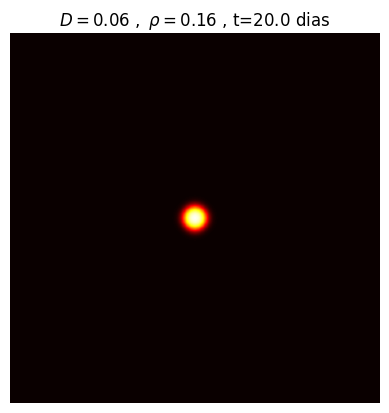

...t = 300...
vt1gd 0.23333333333333334 vt2flair 0.36666666666666664 vgeom 0.2924988129130707 diff 4.0


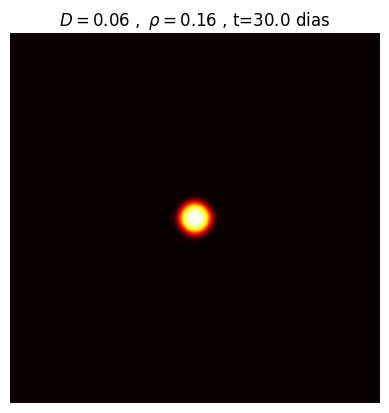

...t = 400...
vt1gd 0.22499999999999998 vt2flair 0.325 vgeom 0.27041634565979916 diff 4.0


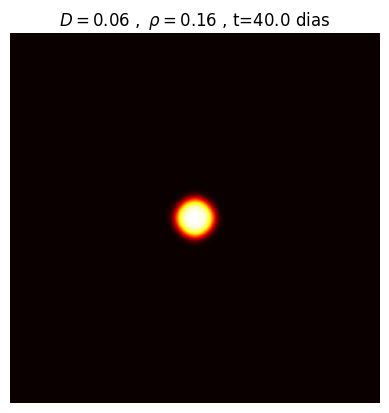

...t = 500...
vt1gd 0.21999999999999997 vt2flair 0.3 vgeom 0.25690465157330256 diff 4.0


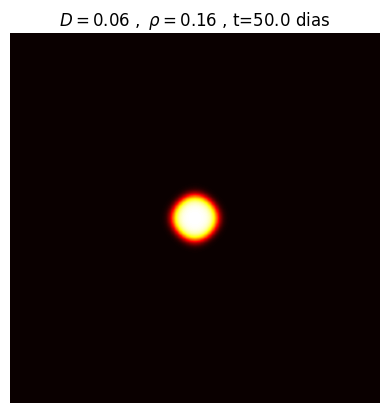

...t = 600...
vt1gd 0.21666666666666667 vt2flair 0.2833333333333333 vgeom 0.24776781245530843 diff 4.0


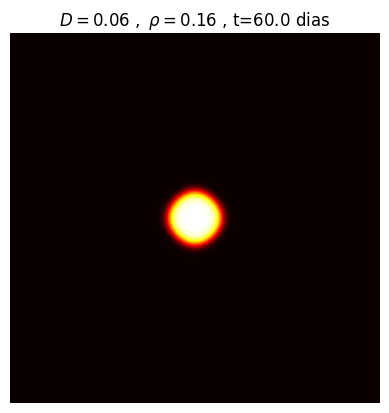

...t = 700...
vt1gd 0.21428571428571427 vt2flair 0.2714285714285714 vgeom 0.24117061451620186 diff 4.0


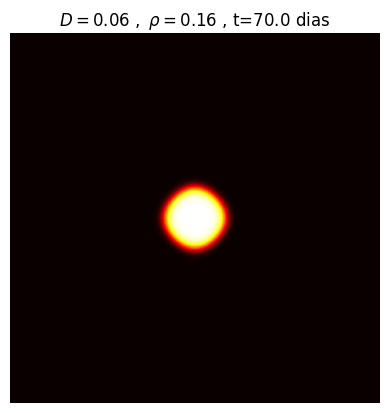

...t = 800...
vt1gd 0.2125 vt2flair 0.26249999999999996 vgeom 0.23618054534613978 diff 4.0


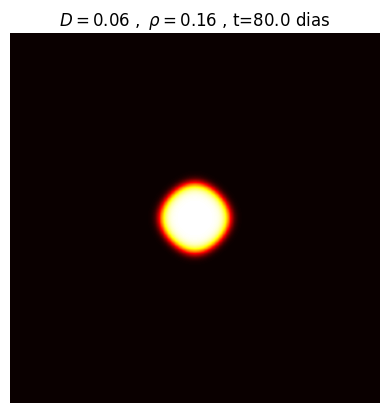

...t = 900...
vt1gd 0.2111111111111111 vt2flair 0.25555555555555554 vgeom 0.23227272178185412 diff 4.0


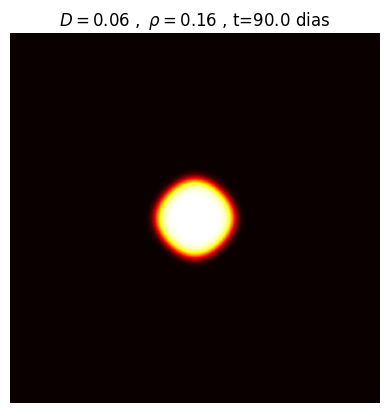

...t = 1000...
vt1gd 0.21 vt2flair 0.25 vgeom 0.229128784747792 diff 4.0


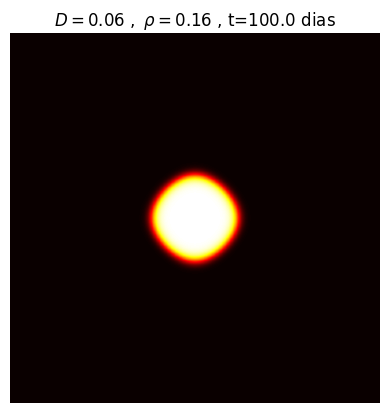

delta r: {'geom': [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]}
speed :  {'t1gd': [0.3, 0.25, 0.23333333333333334, 0.22499999999999998, 0.21999999999999997, 0.21666666666666667, 0.21428571428571427, 0.2125, 0.2111111111111111, 0.21], 't2flair': [0.7000000000000001, 0.44999999999999996, 0.36666666666666664, 0.325, 0.3, 0.2833333333333333, 0.2714285714285714, 0.26249999999999996, 0.25555555555555554, 0.25], 'geom': [0.45825756949558405, 0.33541019662496846, 0.2924988129130707, 0.27041634565979916, 0.25690465157330256, 0.24776781245530843, 0.24117061451620186, 0.23618054534613978, 0.23227272178185412, 0.229128784747792]}

D = 0.28500000000000003 , rho = 0.16
...t = 100...
vt1gd 0.3 vt2flair 0.7000000000000001 vgeom 0.45825756949558405 diff 4.0


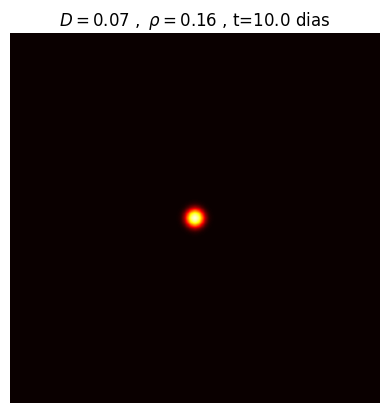

...t = 200...
vt1gd 0.25 vt2flair 0.44999999999999996 vgeom 0.33541019662496846 diff 4.0


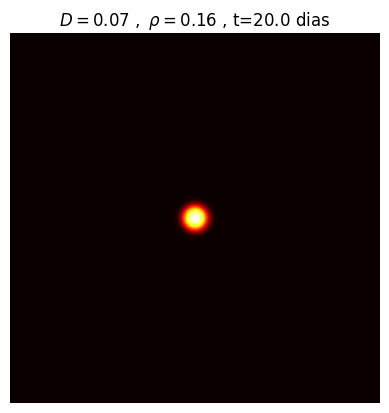

...t = 300...
vt1gd 0.23333333333333334 vt2flair 0.36666666666666664 vgeom 0.2924988129130707 diff 4.0


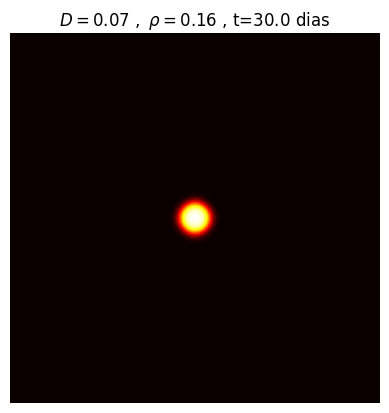

...t = 400...
vt1gd 0.22499999999999998 vt2flair 0.325 vgeom 0.27041634565979916 diff 4.0


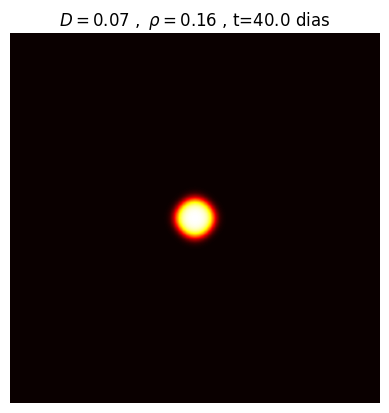

...t = 500...
vt1gd 0.21999999999999997 vt2flair 0.3 vgeom 0.25690465157330256 diff 4.0


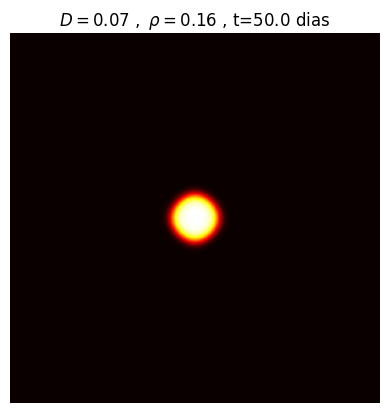

...t = 600...
vt1gd 0.21666666666666667 vt2flair 0.2833333333333333 vgeom 0.24776781245530843 diff 4.0


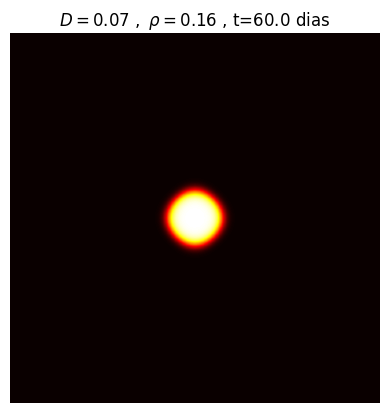

...t = 700...
vt1gd 0.21428571428571427 vt2flair 0.2714285714285714 vgeom 0.24117061451620186 diff 4.0


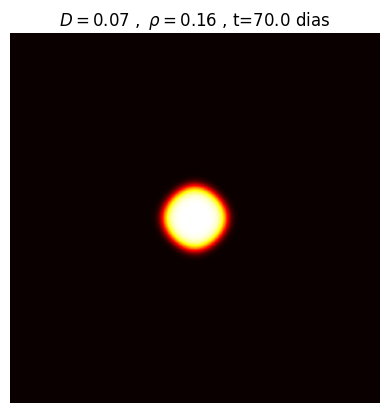

...t = 800...
vt1gd 0.2125 vt2flair 0.26249999999999996 vgeom 0.23618054534613978 diff 4.0


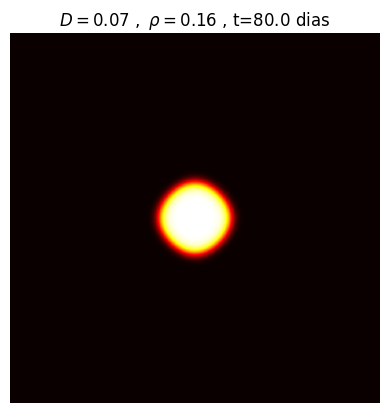

...t = 900...
vt1gd 0.2111111111111111 vt2flair 0.27777777777777773 vgeom 0.2421610524189263 diff 6.0


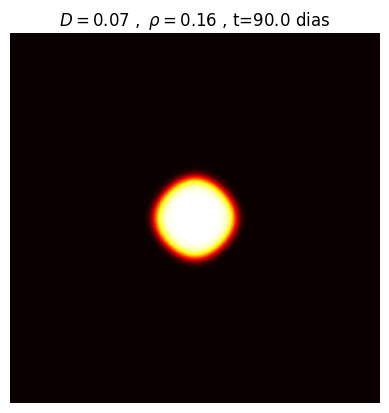

...t = 1000...
vt1gd 0.21 vt2flair 0.26999999999999996 vgeom 0.23811761799581313 diff 6.0


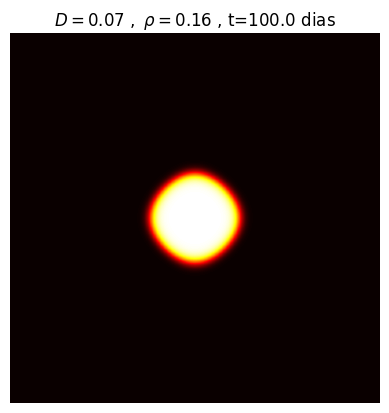

delta r: {'geom': [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 6.0, 6.0]}
speed :  {'t1gd': [0.3, 0.25, 0.23333333333333334, 0.22499999999999998, 0.21999999999999997, 0.21666666666666667, 0.21428571428571427, 0.2125, 0.2111111111111111, 0.21], 't2flair': [0.7000000000000001, 0.44999999999999996, 0.36666666666666664, 0.325, 0.3, 0.2833333333333333, 0.2714285714285714, 0.26249999999999996, 0.27777777777777773, 0.26999999999999996], 'geom': [0.45825756949558405, 0.33541019662496846, 0.2924988129130707, 0.27041634565979916, 0.25690465157330256, 0.24776781245530843, 0.24117061451620186, 0.23618054534613978, 0.2421610524189263, 0.23811761799581313]}

D = 0.32 , rho = 0.16
...t = 100...
vt1gd 0.3 vt2flair 0.7000000000000001 vgeom 0.45825756949558405 diff 4.0


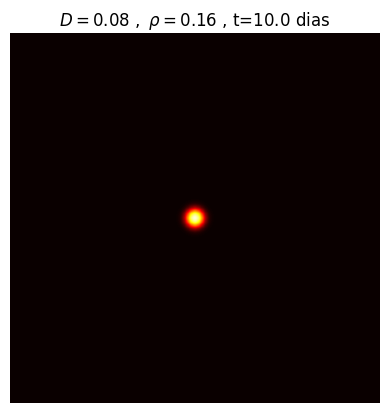

...t = 200...
vt1gd 0.25 vt2flair 0.44999999999999996 vgeom 0.33541019662496846 diff 4.0


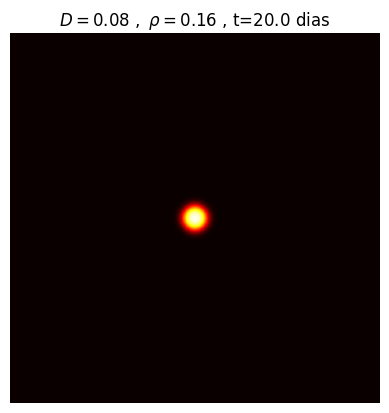

...t = 300...
vt1gd 0.23333333333333334 vt2flair 0.36666666666666664 vgeom 0.2924988129130707 diff 4.0


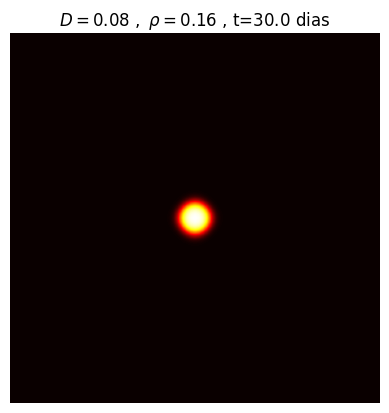

...t = 400...
vt1gd 0.22499999999999998 vt2flair 0.325 vgeom 0.27041634565979916 diff 4.0


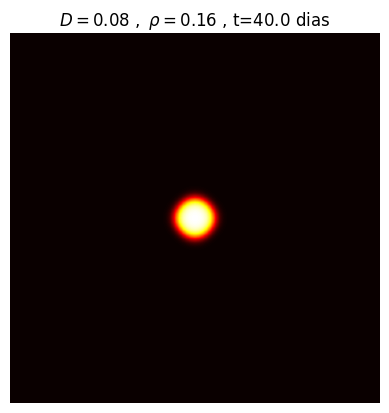

...t = 500...
vt1gd 0.21999999999999997 vt2flair 0.3 vgeom 0.25690465157330256 diff 4.0


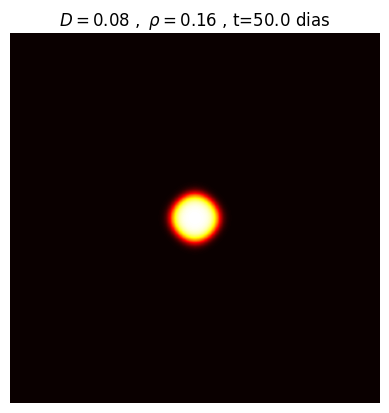

...t = 600...
vt1gd 0.21666666666666667 vt2flair 0.2833333333333333 vgeom 0.24776781245530843 diff 4.0


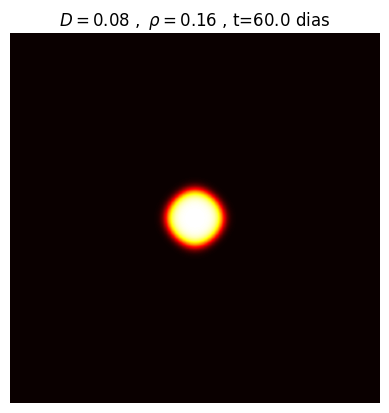

...t = 700...
vt1gd 0.21428571428571427 vt2flair 0.2714285714285714 vgeom 0.24117061451620186 diff 4.0


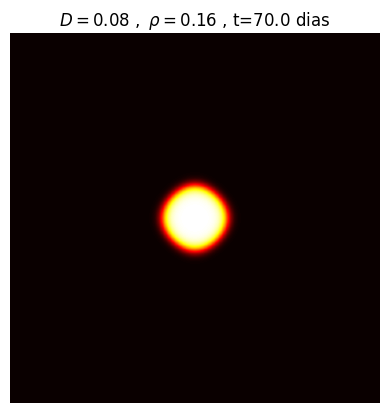

...t = 800...
vt1gd 0.2125 vt2flair 0.2875 vgeom 0.24717149916606485 diff 6.0


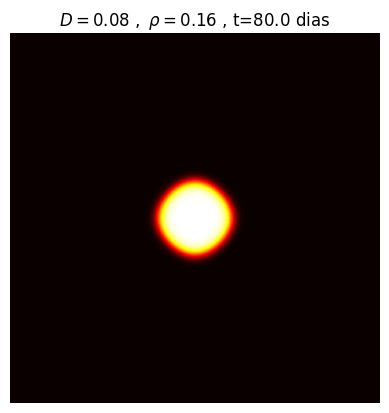

...t = 900...
vt1gd 0.23333333333333334 vt2flair 0.27777777777777773 vgeom 0.2545875386086578 diff 4.0


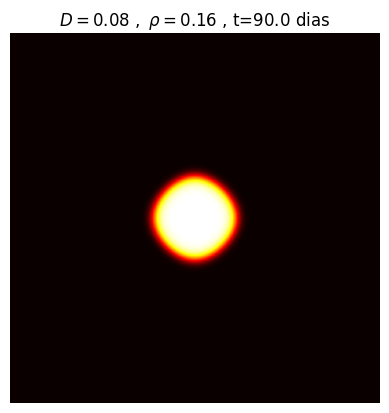

...t = 1000...
vt1gd 0.22999999999999998 vt2flair 0.26999999999999996 vgeom 0.24919871588754222 diff 4.0


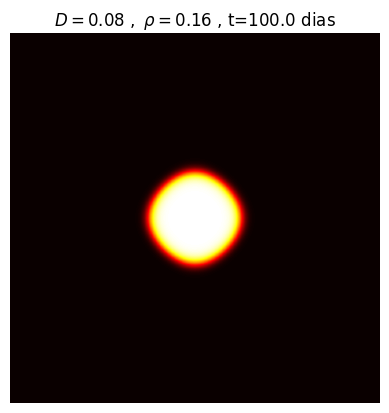

delta r: {'geom': [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 6.0, 4.0, 4.0]}
speed :  {'t1gd': [0.3, 0.25, 0.23333333333333334, 0.22499999999999998, 0.21999999999999997, 0.21666666666666667, 0.21428571428571427, 0.2125, 0.23333333333333334, 0.22999999999999998], 't2flair': [0.7000000000000001, 0.44999999999999996, 0.36666666666666664, 0.325, 0.3, 0.2833333333333333, 0.2714285714285714, 0.2875, 0.27777777777777773, 0.26999999999999996], 'geom': [0.45825756949558405, 0.33541019662496846, 0.2924988129130707, 0.27041634565979916, 0.25690465157330256, 0.24776781245530843, 0.24117061451620186, 0.24717149916606485, 0.2545875386086578, 0.24919871588754222]}

D = 0.25 , rho = 0.18
...t = 100...
vt1gd 0.3 vt2flair 0.7000000000000001 vgeom 0.45825756949558405 diff 4.0


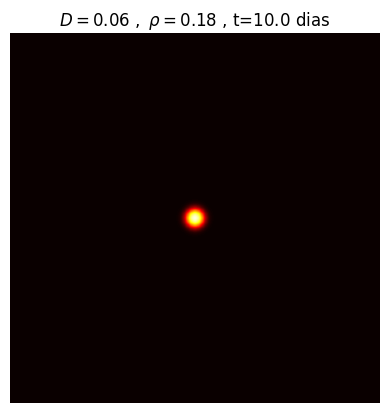

...t = 200...
vt1gd 0.25 vt2flair 0.44999999999999996 vgeom 0.33541019662496846 diff 4.0


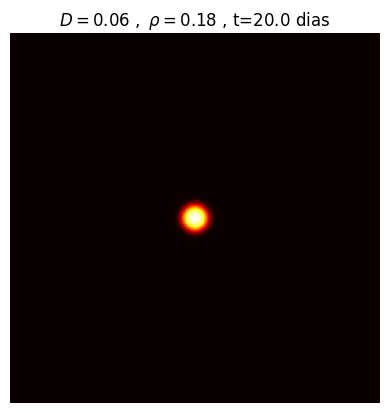

...t = 300...
vt1gd 0.23333333333333334 vt2flair 0.36666666666666664 vgeom 0.2924988129130707 diff 4.0


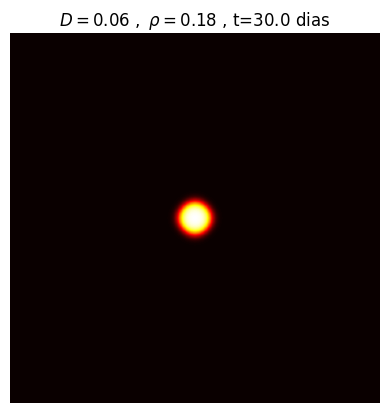

...t = 400...
vt1gd 0.22499999999999998 vt2flair 0.325 vgeom 0.27041634565979916 diff 4.0


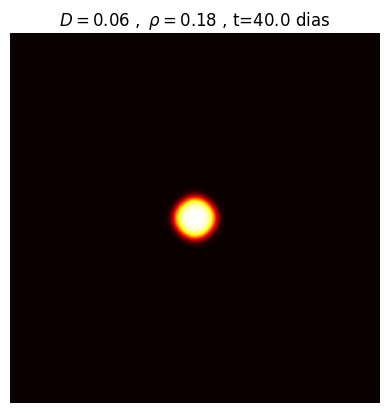

...t = 500...
vt1gd 0.21999999999999997 vt2flair 0.3 vgeom 0.25690465157330256 diff 4.0


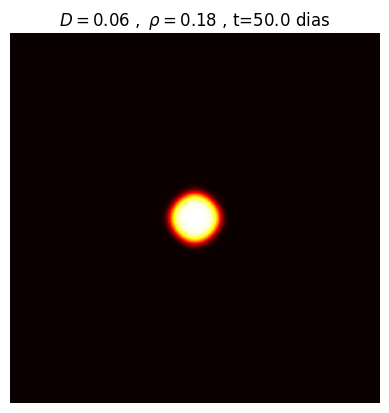

...t = 600...
vt1gd 0.21666666666666667 vt2flair 0.2833333333333333 vgeom 0.24776781245530843 diff 4.0


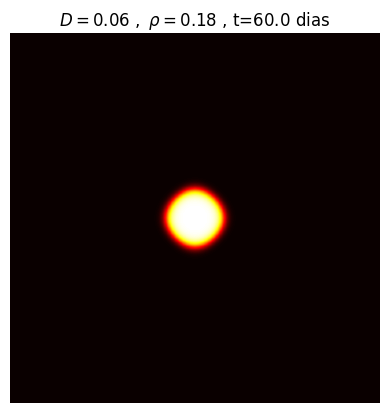

...t = 700...
vt1gd 0.21428571428571427 vt2flair 0.3 vgeom 0.253546276418555 diff 6.0


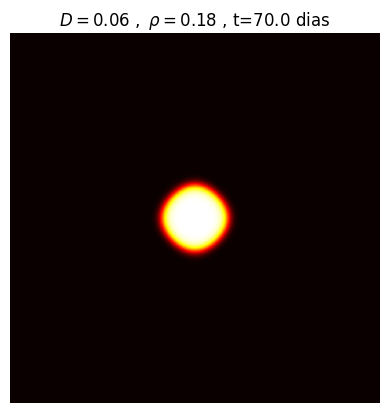

...t = 800...
vt1gd 0.2375 vt2flair 0.2875 vgeom 0.2613068120045859 diff 4.0


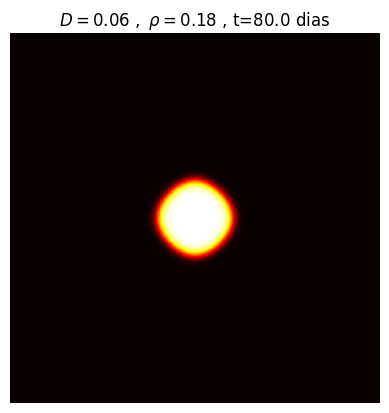

...t = 900...
vt1gd 0.23333333333333334 vt2flair 0.27777777777777773 vgeom 0.2545875386086578 diff 4.0


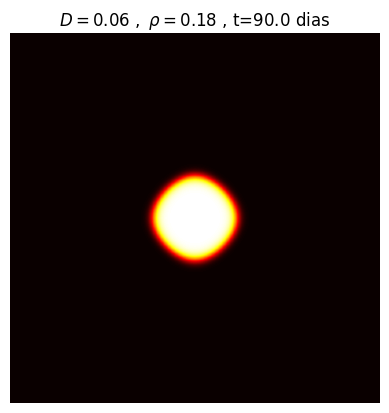

...t = 1000...
vt1gd 0.22999999999999998 vt2flair 0.26999999999999996 vgeom 0.24919871588754222 diff 4.0


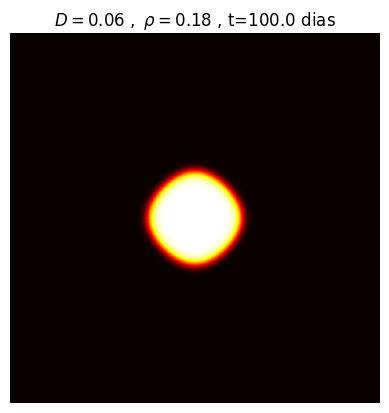

delta r: {'geom': [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 6.0, 4.0, 4.0, 4.0]}
speed :  {'t1gd': [0.3, 0.25, 0.23333333333333334, 0.22499999999999998, 0.21999999999999997, 0.21666666666666667, 0.21428571428571427, 0.2375, 0.23333333333333334, 0.22999999999999998], 't2flair': [0.7000000000000001, 0.44999999999999996, 0.36666666666666664, 0.325, 0.3, 0.2833333333333333, 0.3, 0.2875, 0.27777777777777773, 0.26999999999999996], 'geom': [0.45825756949558405, 0.33541019662496846, 0.2924988129130707, 0.27041634565979916, 0.25690465157330256, 0.24776781245530843, 0.253546276418555, 0.2613068120045859, 0.2545875386086578, 0.24919871588754222]}

D = 0.28500000000000003 , rho = 0.18
...t = 100...
vt1gd 0.3 vt2flair 0.7000000000000001 vgeom 0.45825756949558405 diff 4.0


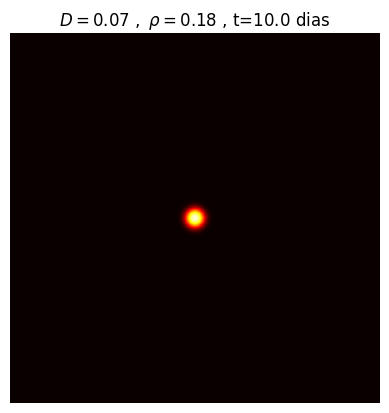

...t = 200...
vt1gd 0.25 vt2flair 0.44999999999999996 vgeom 0.33541019662496846 diff 4.0


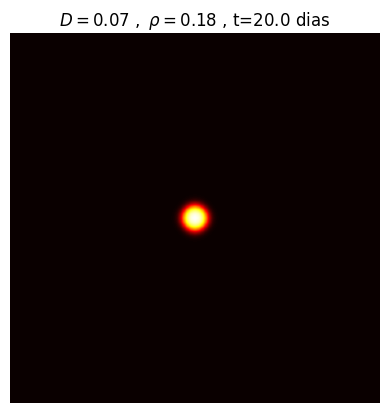

...t = 300...
vt1gd 0.23333333333333334 vt2flair 0.36666666666666664 vgeom 0.2924988129130707 diff 4.0


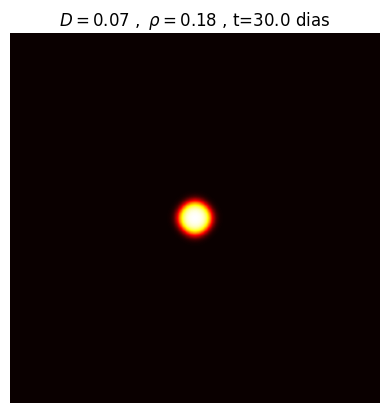

...t = 400...
vt1gd 0.22499999999999998 vt2flair 0.325 vgeom 0.27041634565979916 diff 4.0


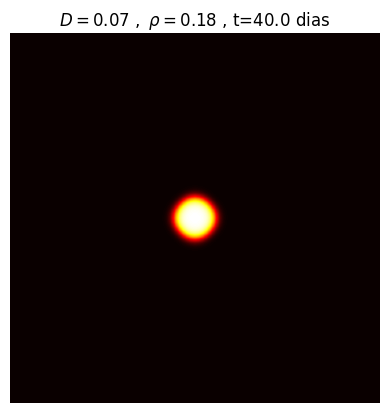

...t = 500...
vt1gd 0.21999999999999997 vt2flair 0.3 vgeom 0.25690465157330256 diff 4.0


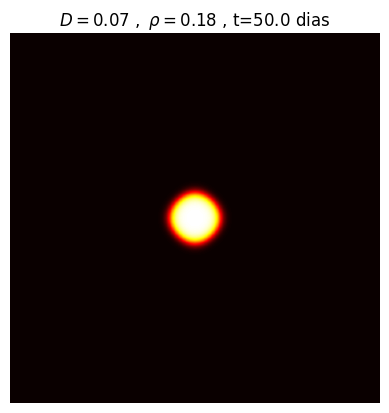

...t = 600...
vt1gd 0.21666666666666667 vt2flair 0.31666666666666665 vgeom 0.2619372274250285 diff 6.0


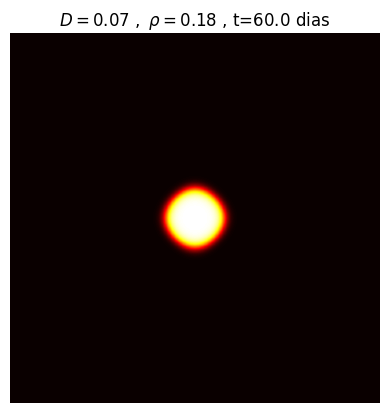

...t = 700...
vt1gd 0.24285714285714285 vt2flair 0.3 vgeom 0.2699206232527312 diff 4.0


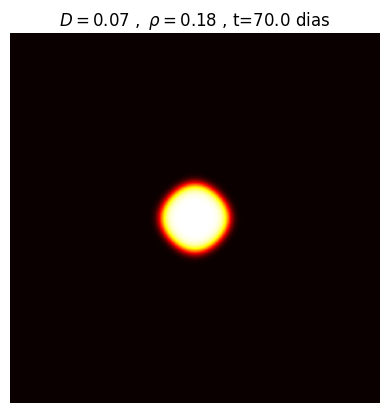

...t = 800...
vt1gd 0.2375 vt2flair 0.2875 vgeom 0.2613068120045859 diff 4.0


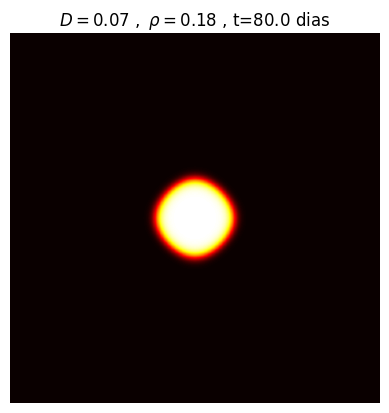

...t = 900...
vt1gd 0.23333333333333334 vt2flair 0.27777777777777773 vgeom 0.2545875386086578 diff 4.0


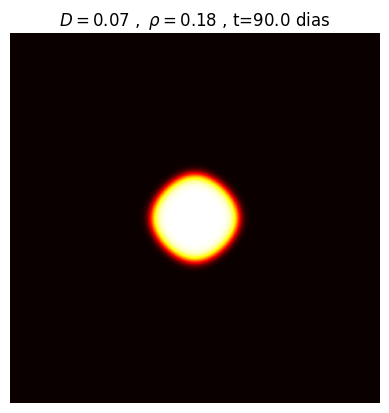

...t = 1000...
vt1gd 0.25 vt2flair 0.29 vgeom 0.2692582403567252 diff 4.0


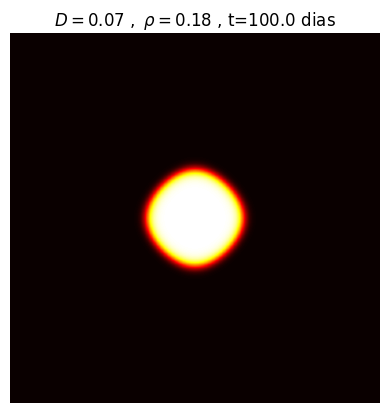

delta r: {'geom': [4.0, 4.0, 4.0, 4.0, 4.0, 6.0, 4.0, 4.0, 4.0, 4.0]}
speed :  {'t1gd': [0.3, 0.25, 0.23333333333333334, 0.22499999999999998, 0.21999999999999997, 0.21666666666666667, 0.24285714285714285, 0.2375, 0.23333333333333334, 0.25], 't2flair': [0.7000000000000001, 0.44999999999999996, 0.36666666666666664, 0.325, 0.3, 0.31666666666666665, 0.3, 0.2875, 0.27777777777777773, 0.29], 'geom': [0.45825756949558405, 0.33541019662496846, 0.2924988129130707, 0.27041634565979916, 0.25690465157330256, 0.2619372274250285, 0.2699206232527312, 0.2613068120045859, 0.2545875386086578, 0.2692582403567252]}

D = 0.32 , rho = 0.18
...t = 100...
vt1gd 0.3 vt2flair 0.7000000000000001 vgeom 0.45825756949558405 diff 4.0


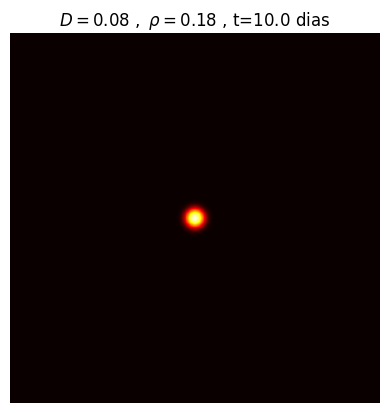

...t = 200...
vt1gd 0.25 vt2flair 0.44999999999999996 vgeom 0.33541019662496846 diff 4.0


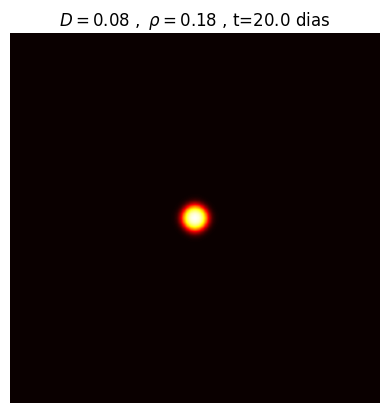

...t = 300...
vt1gd 0.23333333333333334 vt2flair 0.36666666666666664 vgeom 0.2924988129130707 diff 4.0


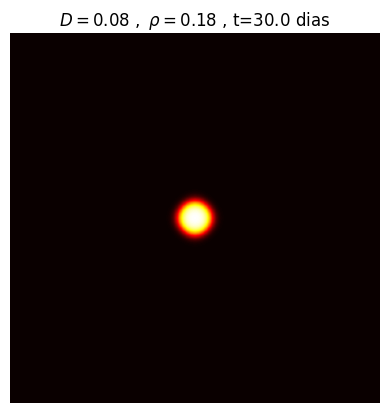

...t = 400...
vt1gd 0.22499999999999998 vt2flair 0.325 vgeom 0.27041634565979916 diff 4.0


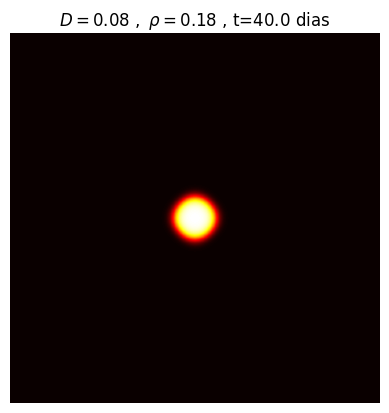

...t = 500...
vt1gd 0.21999999999999997 vt2flair 0.34 vgeom 0.27349588662354685 diff 6.0


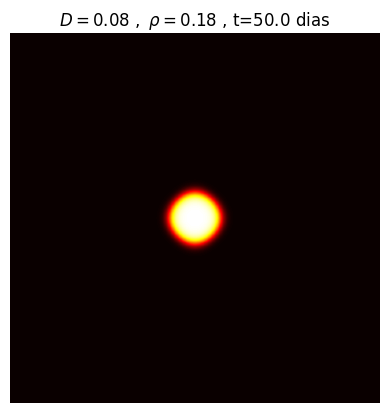

...t = 600...
vt1gd 0.25 vt2flair 0.31666666666666665 vgeom 0.2813657169355689 diff 4.0


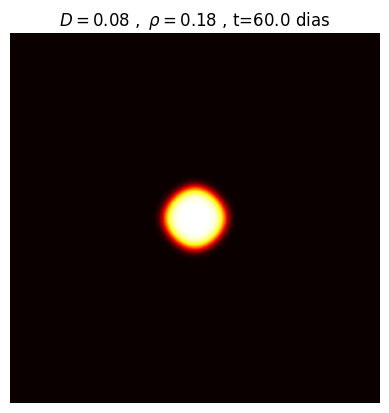

...t = 700...
vt1gd 0.24285714285714285 vt2flair 0.3 vgeom 0.2699206232527312 diff 4.0


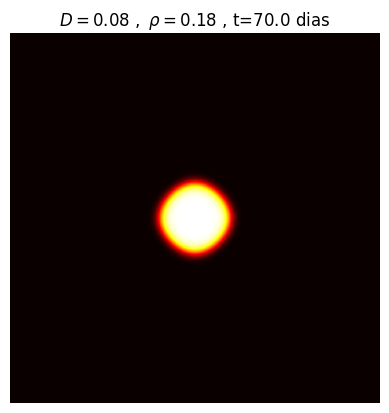

...t = 800...
vt1gd 0.2375 vt2flair 0.3125 vgeom 0.2724311839712921 diff 6.0


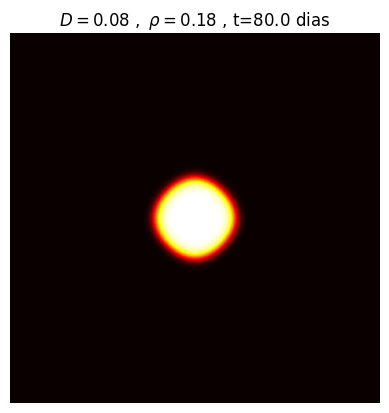

...t = 900...
vt1gd 0.25555555555555554 vt2flair 0.3 vgeom 0.27688746209726917 diff 4.0


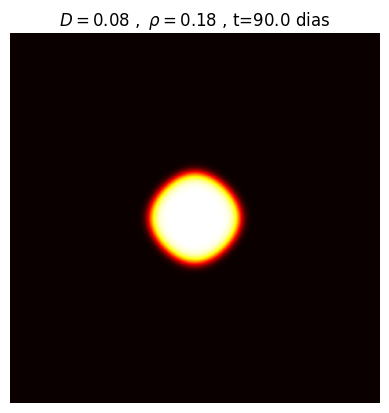

...t = 1000...
vt1gd 0.25 vt2flair 0.29 vgeom 0.2692582403567252 diff 4.0


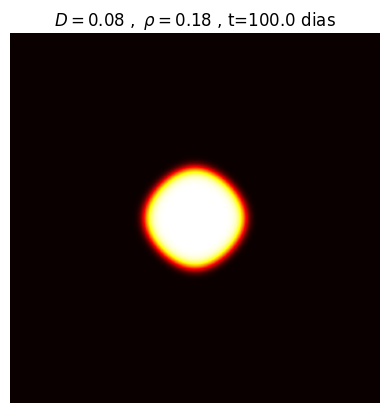

delta r: {'geom': [4.0, 4.0, 4.0, 4.0, 6.0, 4.0, 4.0, 6.0, 4.0, 4.0]}
speed :  {'t1gd': [0.3, 0.25, 0.23333333333333334, 0.22499999999999998, 0.21999999999999997, 0.25, 0.24285714285714285, 0.2375, 0.25555555555555554, 0.25], 't2flair': [0.7000000000000001, 0.44999999999999996, 0.36666666666666664, 0.325, 0.34, 0.31666666666666665, 0.3, 0.3125, 0.3, 0.29], 'geom': [0.45825756949558405, 0.33541019662496846, 0.2924988129130707, 0.27041634565979916, 0.27349588662354685, 0.2813657169355689, 0.2699206232527312, 0.2724311839712921, 0.27688746209726917, 0.2692582403567252]}

D = 0.25 , rho = 0.2
...t = 100...
vt1gd 0.3 vt2flair 0.7000000000000001 vgeom 0.45825756949558405 diff 4.0


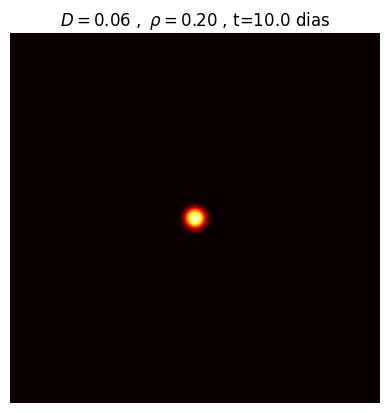

...t = 200...
vt1gd 0.25 vt2flair 0.44999999999999996 vgeom 0.33541019662496846 diff 4.0


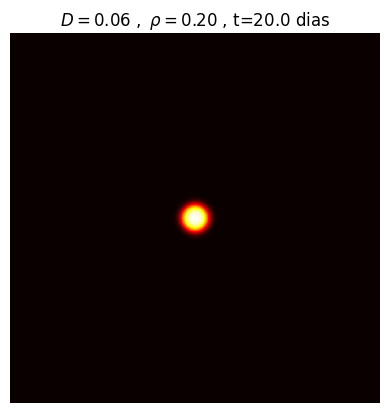

...t = 300...
vt1gd 0.23333333333333334 vt2flair 0.36666666666666664 vgeom 0.2924988129130707 diff 4.0


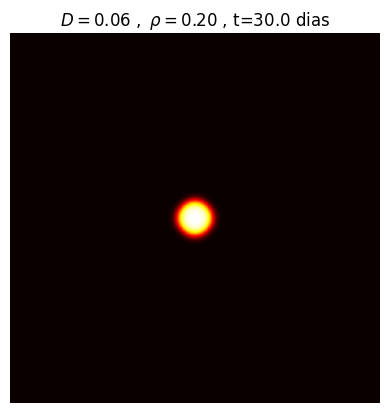

...t = 400...
vt1gd 0.22499999999999998 vt2flair 0.325 vgeom 0.27041634565979916 diff 4.0


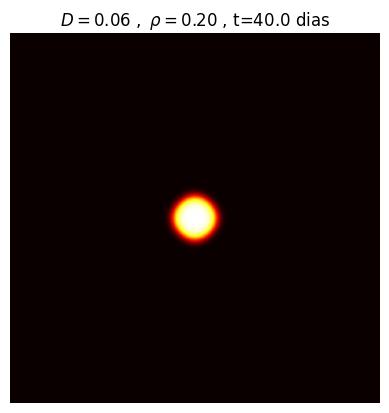

...t = 500...
vt1gd 0.25999999999999995 vt2flair 0.34 vgeom 0.2973213749463701 diff 4.0


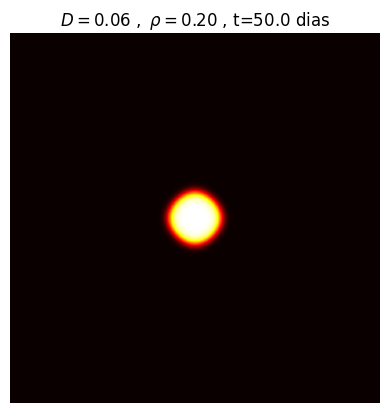

...t = 600...
vt1gd 0.25 vt2flair 0.31666666666666665 vgeom 0.2813657169355689 diff 4.0


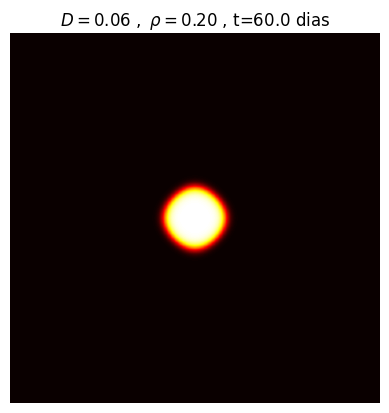

...t = 700...
vt1gd 0.24285714285714285 vt2flair 0.3 vgeom 0.2699206232527312 diff 4.0


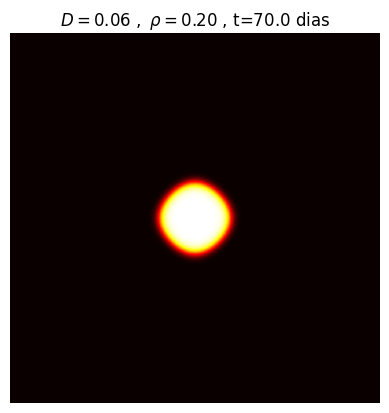

...t = 800...
vt1gd 0.2375 vt2flair 0.2875 vgeom 0.2613068120045859 diff 4.0


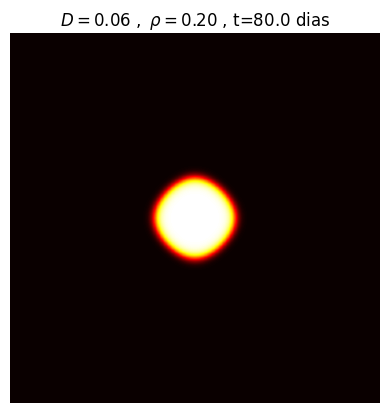

...t = 900...
vt1gd 0.25555555555555554 vt2flair 0.3 vgeom 0.27688746209726917 diff 4.0


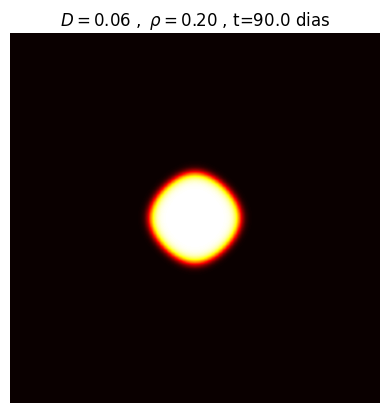

...t = 1000...
vt1gd 0.25 vt2flair 0.29 vgeom 0.2692582403567252 diff 4.0


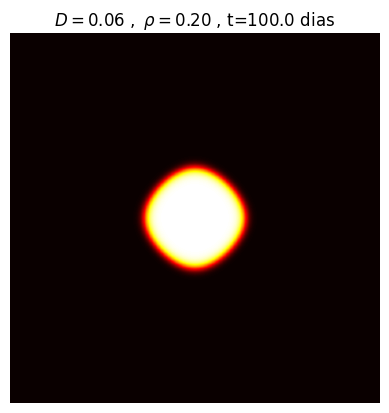

delta r: {'geom': [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]}
speed :  {'t1gd': [0.3, 0.25, 0.23333333333333334, 0.22499999999999998, 0.25999999999999995, 0.25, 0.24285714285714285, 0.2375, 0.25555555555555554, 0.25], 't2flair': [0.7000000000000001, 0.44999999999999996, 0.36666666666666664, 0.325, 0.34, 0.31666666666666665, 0.3, 0.2875, 0.3, 0.29], 'geom': [0.45825756949558405, 0.33541019662496846, 0.2924988129130707, 0.27041634565979916, 0.2973213749463701, 0.2813657169355689, 0.2699206232527312, 0.2613068120045859, 0.27688746209726917, 0.2692582403567252]}

D = 0.28500000000000003 , rho = 0.2
...t = 100...
vt1gd 0.3 vt2flair 0.7000000000000001 vgeom 0.45825756949558405 diff 4.0


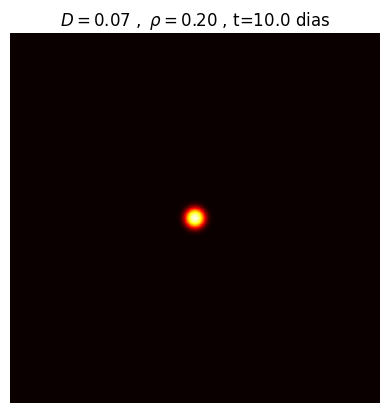

...t = 200...
vt1gd 0.25 vt2flair 0.44999999999999996 vgeom 0.33541019662496846 diff 4.0


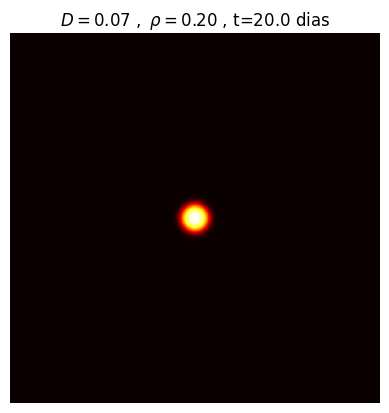

...t = 300...
vt1gd 0.23333333333333334 vt2flair 0.36666666666666664 vgeom 0.2924988129130707 diff 4.0


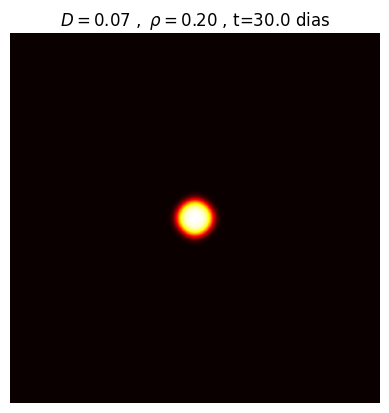

...t = 400...
vt1gd 0.22499999999999998 vt2flair 0.37499999999999994 vgeom 0.2904737509655562 diff 6.0


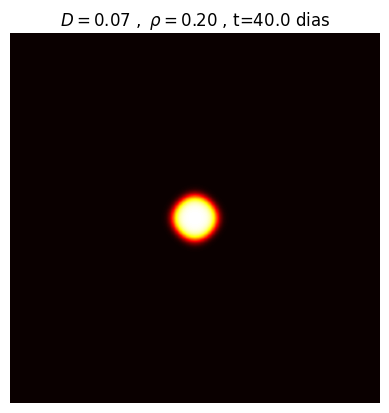

...t = 500...
vt1gd 0.25999999999999995 vt2flair 0.34 vgeom 0.2973213749463701 diff 4.0


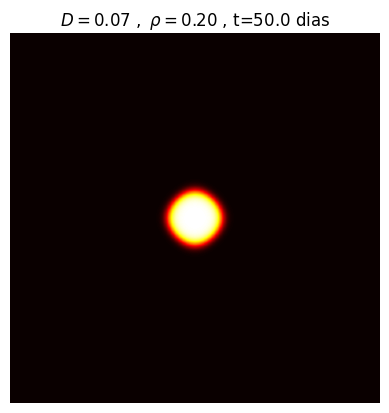

...t = 600...
vt1gd 0.25 vt2flair 0.31666666666666665 vgeom 0.2813657169355689 diff 4.0


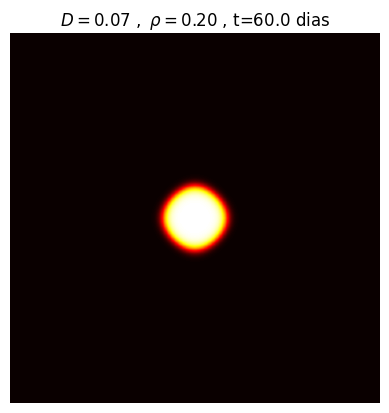

...t = 700...
vt1gd 0.24285714285714285 vt2flair 0.3285714285714285 vgeom 0.28248171333264555 diff 6.0


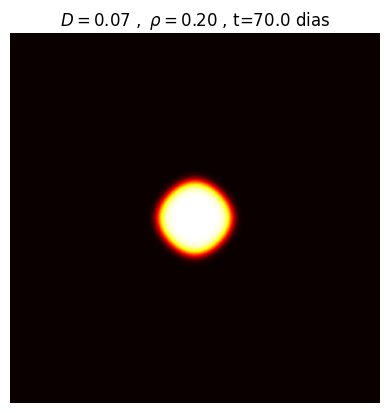

...t = 800...
vt1gd 0.26249999999999996 vt2flair 0.3125 vgeom 0.28641098093474 diff 4.0


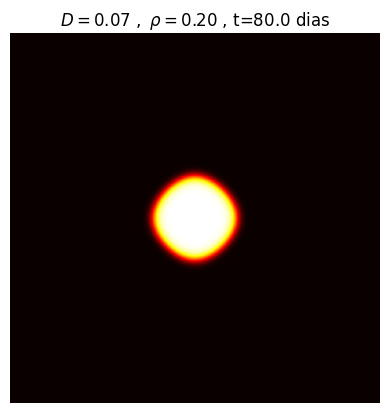

...t = 900...
vt1gd 0.25555555555555554 vt2flair 0.3 vgeom 0.27688746209726917 diff 4.0


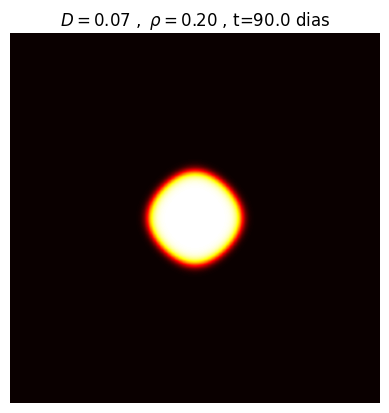

...t = 1000...
vt1gd 0.26999999999999996 vt2flair 0.31 vgeom 0.2893095228297886 diff 4.0


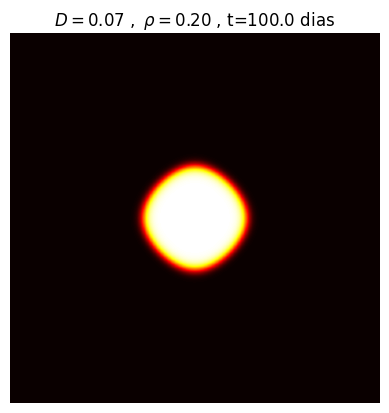

delta r: {'geom': [4.0, 4.0, 4.0, 6.0, 4.0, 4.0, 6.0, 4.0, 4.0, 4.0]}
speed :  {'t1gd': [0.3, 0.25, 0.23333333333333334, 0.22499999999999998, 0.25999999999999995, 0.25, 0.24285714285714285, 0.26249999999999996, 0.25555555555555554, 0.26999999999999996], 't2flair': [0.7000000000000001, 0.44999999999999996, 0.36666666666666664, 0.37499999999999994, 0.34, 0.31666666666666665, 0.3285714285714285, 0.3125, 0.3, 0.31], 'geom': [0.45825756949558405, 0.33541019662496846, 0.2924988129130707, 0.2904737509655562, 0.2973213749463701, 0.2813657169355689, 0.28248171333264555, 0.28641098093474, 0.27688746209726917, 0.2893095228297886]}

D = 0.32 , rho = 0.2
...t = 100...
vt1gd 0.3 vt2flair 0.7000000000000001 vgeom 0.45825756949558405 diff 4.0


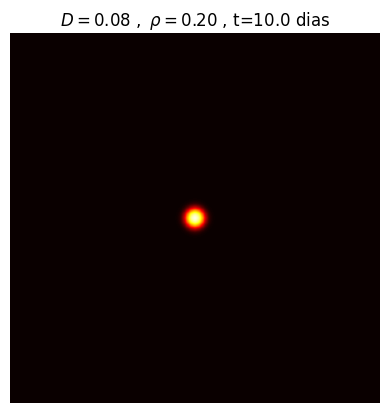

...t = 200...
vt1gd 0.25 vt2flair 0.44999999999999996 vgeom 0.33541019662496846 diff 4.0


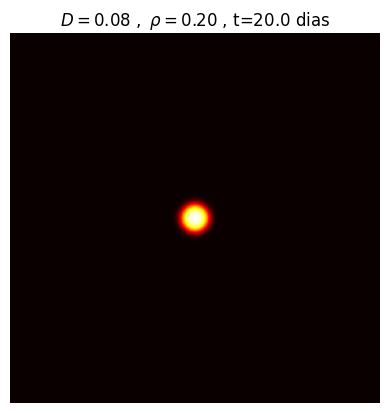

...t = 300...
vt1gd 0.23333333333333334 vt2flair 0.36666666666666664 vgeom 0.2924988129130707 diff 4.0


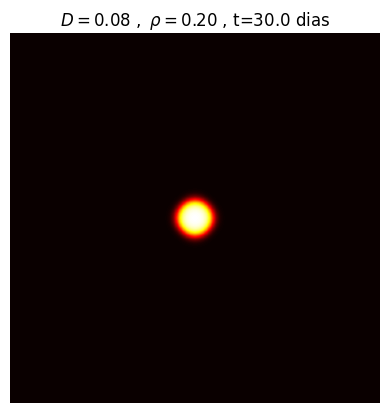

...t = 400...
vt1gd 0.27499999999999997 vt2flair 0.37499999999999994 vgeom 0.32113081446662817 diff 4.0


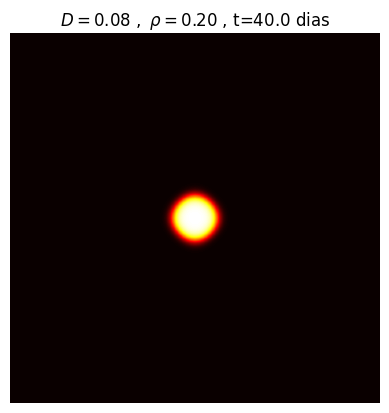

...t = 500...
vt1gd 0.25999999999999995 vt2flair 0.34 vgeom 0.2973213749463701 diff 4.0


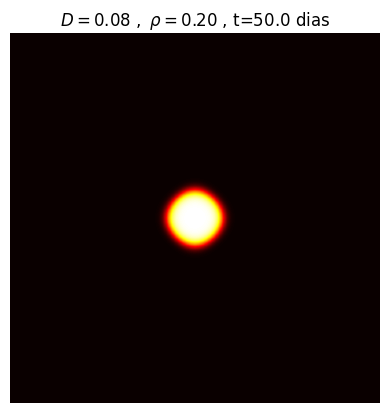

...t = 600...
vt1gd 0.25 vt2flair 0.31666666666666665 vgeom 0.2813657169355689 diff 4.0


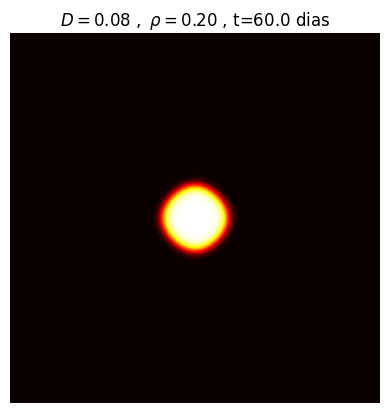

...t = 700...
vt1gd 0.2714285714285714 vt2flair 0.3285714285714285 vgeom 0.29863635657666954 diff 4.0


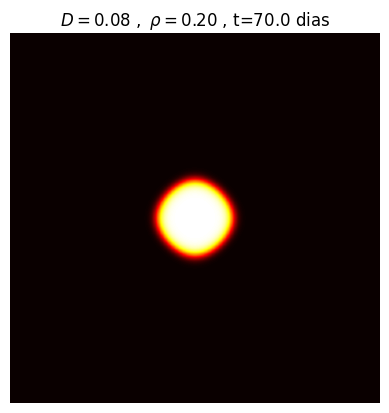

...t = 800...
vt1gd 0.26249999999999996 vt2flair 0.3125 vgeom 0.28641098093474 diff 4.0


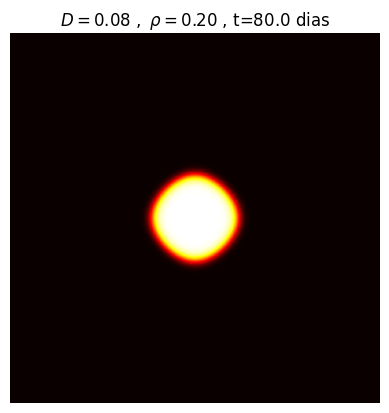

...t = 900...
vt1gd 0.27777777777777773 vt2flair 0.3222222222222222 vgeom 0.29917582261858355 diff 4.0


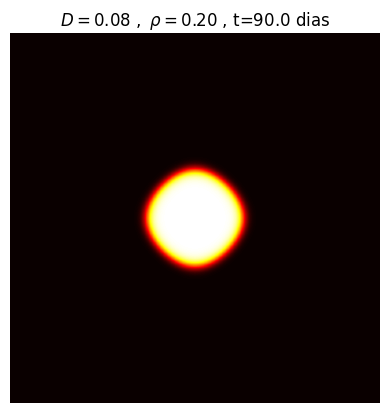

...t = 1000...
vt1gd 0.26999999999999996 vt2flair 0.31 vgeom 0.2893095228297886 diff 4.0


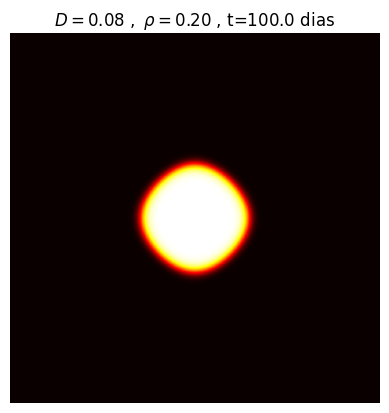

delta r: {'geom': [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]}
speed :  {'t1gd': [0.3, 0.25, 0.23333333333333334, 0.27499999999999997, 0.25999999999999995, 0.25, 0.2714285714285714, 0.26249999999999996, 0.27777777777777773, 0.26999999999999996], 't2flair': [0.7000000000000001, 0.44999999999999996, 0.36666666666666664, 0.37499999999999994, 0.34, 0.31666666666666665, 0.3285714285714285, 0.3125, 0.3222222222222222, 0.31], 'geom': [0.45825756949558405, 0.33541019662496846, 0.2924988129130707, 0.32113081446662817, 0.2973213749463701, 0.2813657169355689, 0.29863635657666954, 0.28641098093474, 0.29917582261858355, 0.2893095228297886]}



In [28]:
# Inicializa una lista vacía U para almacenar los resultados de las simulaciones
U = []
for rho in rhos:
  for D in Ds:
    # Imprimo valores actuales de D y rho que se están utilizando en la simulación
    print('D =', D, ', rho =', rho)
    # Creo una instancia de la clase CNicholson2D 
    cn2D = CNicholson2D(D=D, rho=rho, Lx=200, Ly=200, Nx=100, Ny=100, T=100.1, sigma=10)
    u = cn2D.simulation() # Ejecuto la simulación y lo guardo en la variable u
    U.append(u)
    print('delta r:', u[1]) # Imprimimos el valor de delta r (diferencia de distancia) del resultado de la simulación
    print('speed : ', u[2]) # Imprimimos la velocidad calculada del resultado de la simulación
    print()


In [ ]:
def viz(i, t):
    plt.imshow(Us[i][t], interpolation='gaussian', cmap=cm.hot)
    plt.title(r'$D={0:1.2f} \, \, , \, \, \rho={1:0.2f}$ , t={2:1.1f} dias'.format(self.D, self.rho, t*self.dt))
    plt.grid(False)
    plt.axis('off')
        

f, ax = plt.subplots(3, 3, figsize=(15,15))


i, t = -1, 100
D, rho = np.sqrt(float(Ds[i])), float(rhos[i])
ax[0, 0].imshow(Us[i][t], interpolation='gaussian', cmap=cm.hot)
ax[0, 0].set_title(r'$D={0:1.2f} \, \, , \, \, \rho={1:0.2f}$ , t={2:3.1f} dias'.format(D, rho, t*0.1))
ax[0, 0].grid(False)
ax[0, 0].axis('off')

i, t = -1, 500
D, rho = np.sqrt(float(Ds[i])), float(rhos[i])
ax[0, 1].imshow(Us[i][t], interpolation='gaussian', cmap=cm.hot)
ax[0, 1].set_title(r't={:3.1f} days'.format(t*0.1))
ax[0, 1].grid(False)
ax[0, 1].axis('off')

i, t = -1, 1000
D, rho = np.sqrt(float(Ds[i])), float(rhos[i])
ax[0, 2].imshow(Us[i][t], interpolation='gaussian', cmap=cm.hot)
ax[0, 2].set_title(r't={:3.1f} days'.format(t*0.1))
ax[0, 2].grid(False)
ax[0, 2].axis('off')
            
  
###

i, t = 80, 100
D, rho = np.sqrt(float(Ds[i])), float(rhos[i])
ax[1, 0].imshow(Us[i][t], interpolation='gaussian', cmap=cm.hot)
ax[1, 0].set_title(r'$D={0:1.2f} \, \, , \, \, \rho={1:0.2f}$ , t={2:3.1f} days'.format(D, rho, t*0.1))
ax[1, 0].grid(False)
ax[1, 0].axis('off')

i, t = 80, 500
D, rho = np.sqrt(float(Ds[i])), float(rhos[i])
ax[1, 1].imshow(Us[i][t], interpolation='gaussian', cmap=cm.hot)
ax[1, 1].set_title(r't={:3.1f} days'.format(t*0.1))
ax[1, 1].grid(False)
ax[1, 1].axis('off')

i, t = 80, 1000
D, rho = np.sqrt(float(Ds[i])), float(rhos[i])
ax[1, 2].imshow(Us[i][t], interpolation='gaussian', cmap=cm.hot)
ax[1, 2].set_title(r't={:3.1f} days'.format(t*0.1))
ax[1, 2].grid(False)
ax[1, 2].axis('off')


###

i, t = 20, 100
D, rho = np.sqrt(float(Ds[i])), float(rhos[i])
ax[2, 0].imshow(Us[i][t], interpolation='gaussian', cmap=cm.hot)
ax[2, 0].set_title(r'$D={0:1.2f} \, \, , \, \, \rho={1:0.2f}$ , t={2:3.1f} days'.format(D, rho, t*0.1))
ax[2, 0].grid(False)
ax[2, 0].axis('off')

i, t = 20, 500
D, rho = np.sqrt(float(Ds[i])), float(rhos[i])
ax[2, 1].imshow(Us[i][t], interpolation='gaussian', cmap=cm.hot)
ax[2, 1].set_title(r't={:3.1f} days'.format(t*0.1))
ax[2, 1].grid(False)
ax[2, 1].axis('off')

i, t = 20, 1000
D, rho = np.sqrt(float(Ds[i])), float(rhos[i])
ax[2, 2].imshow(Us[i][t], interpolation='gaussian', cmap=cm.hot)
ax[2, 2].set_title(r't={:3.1f} days'.format(t*0.1))
ax[2, 2].grid(False)
ax[2, 2].axis('off')

f.savefig('imshows.jpg', dpi=300)